In [1]:
#Librerias
import numpy as np
from pathlib import Path
from PIL import Image
import util_func as fc
import time

#Librerías de PyTorch
import torch  #PyTorch library
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn #Neural networks library
import torch.nn.functional as F

#Librerias utiles para plotear
import matplotlib.pyplot as plt
%matplotlib inline 
#plots in the line below the code, inside the notebook 

#Nombre del proyecto
project_name = 'Deteccion de nubes'

## Preparando los datos

Para empezar, cargo en la lista a la que denomino *'total_list'* los nombres de todos los archivos. Esta lista contiene tres sub-listas, cada una de ellas contiene los nombres de los archivos que van a pertenecer al conjunto de datos de entrenamiento(*training*), validacion y prueba(*test*) respectivamente. 

In [2]:
total_list = fc.data_split('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud', 15000, 5000)
len(total_list)

3

In [3]:
#Cargo la direccion de la carpeta que contiene todos los canales en una variable, como objeto 'Path'
path_ppal = Path('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud')

In [4]:
#Cargo el dataset de entrenamiento, es el primer objeto de la lista total_lista
train_dataset = fc.CloudDataset(path_ppal/'train_red_additional_to38cloud', 
                    path_ppal/'train_green_additional_to38cloud', 
                    path_ppal/'train_blue_additional_to38cloud', 
                    path_ppal/'train_nir_additional_to38cloud',
                    path_ppal/'train_gt_additional_to38cloud',
                    total_list[0])
len(train_dataset)

15000

In [5]:
#Cargo el dataset de validación, es el segundo objeto de la lista total_list
val_dataset = fc.CloudDataset(path_ppal/'train_red_additional_to38cloud', 
                    path_ppal/'train_green_additional_to38cloud', 
                    path_ppal/'train_blue_additional_to38cloud', 
                    path_ppal/'train_nir_additional_to38cloud',
                    path_ppal/'train_gt_additional_to38cloud',
                    total_list[1])
len(val_dataset)

5000

In [6]:
#Cargo el dataset de validación, es el tercer objeto de la lista total_list
test_dataset = fc.CloudDataset(path_ppal/'train_red_additional_to38cloud', 
                    path_ppal/'train_green_additional_to38cloud', 
                    path_ppal/'train_blue_additional_to38cloud', 
                    path_ppal/'train_nir_additional_to38cloud',
                    path_ppal/'train_gt_additional_to38cloud',
                    total_list[2])
len(test_dataset)

6301

Creo los *dataloaders* donde cargo los *datasets* y defino el tamaño del lote (*batch*) para cargar el conjunto de datos en lotes al entrenarlo. 

In [7]:
batch_size = 6

In [8]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

## Mover los datos al GPU
A continuación defino una serie de funciones cuyo objetivo es mover los datos al GPU para poder utilizarlo y entrenar la red con este dispositivo. Si utilizara sólo el CPU tardaria mucho tiempo, incluso es probable que no sea posible. 
[Fuente](https://jovian.ml/forum/c/pytorch-zero-to-gans/18)

In [9]:
torch.cuda.is_available() #Detecta si hay un GPU disponible

True

In [10]:
#Elige un GPU si hay uno disponible. Si no, elige un CPU.
device = fc.get_default_device()
device

device(type='cuda')

In [11]:
def to_device(data, device):
    """Mueve tensor(es) al dispositivo (CPU O GPU) elegido"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Cantidad de batches o lotes"""
        return len(self.dl)

In [12]:
#Cargo los datos con un Dataloader en el dispositivo correspondiente
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

## Modelo

In [13]:
#The accuracy we will define our own, that will be basically 
#the number of matched pixels (mask == prediction) divided by the total number of pixels in a batch
def accuracy(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        loss_fn = nn.CrossEntropyLoss()
        images, masks = batch 
        #input, targets Carga un lote de datos, cada imagen con su respectiva máscara de nubes
        out = self(images)     # output Genera las predicciones
        loss = loss_fn(out, masks) # Calcula las perdidas para cada prediccion (diferencia entre predicción y mascara)        
        return loss
    
    def validation_step(self, batch):
        loss_fn = nn.CrossEntropyLoss()
        images, masks = batch      # Carga un lote de datos, cada imagen con su respectiva máscara
        out = self(images)          # Generate predictions
        loss = loss_fn(out, masks.long()) # Calculate loss
        acc = accuracy(out, masks) # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs] # Lista de las perdidas de cada batch
        epoch_loss = torch.stack(batch_losses).mean()   # Junta las losses de todos los lotes
        batch_accs = [x['val_acc'] for x in outputs]    # Lista de las exctitudes de cada batch
        epoch_acc = torch.stack(batch_accs).mean()      # Junta las accuracies de todos los lotes
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result): #Imprime los resultados al terminar de correr cada epoch
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### CNN

In [14]:
class SimpleCNN(ImageClassificationBase):
    
    def __init__(self):
        super().__init__() 
        
        self.encod = nn.Sequential(
            nn.Conv2d(4,32, kernel_size=5, stride=1, padding=2), #out = 32x384x384 cambie 16 por 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 32x192x192, acum = 1/2

            nn.Conv2d(32,64, kernel_size=5, stride=1, padding=2), #out = 64x192x192
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 64x96x96, acum = 1/4
        
        
            nn.Conv2d(64,128, kernel_size=5, stride=1, padding=2), #out=128x96x96
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 128x48x48, acum = 1/8
        
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2), #out = 256x48x48
            nn.BatchNorm2d(256),
            nn.ReLU(),    
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 256x24x24, acum = 1/16
        
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2), #out = 256x24x24
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 512x12x12, acum = 1/32
            
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), #out = 1024x24x24
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 1024x6x6, acum = 1/64
            
            nn.Conv2d(1024, 1024, kernel_size=5, stride=1, padding=2), #out = 2048x12x12
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) #out = 1024x3x3, acum = 1/128
            
        )
        
        self.decod = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=3,stride=1, padding=2), #out = 512x3x3
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.UpsamplingNearest2d([6,6], scale_factor=None), #out=128x6x6 
            
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=3,stride=1, padding=2), #out = 256x6x6
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.UpsamplingNearest2d([12,12], scale_factor=None), #out=128x6x6 
            
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=5,stride=1, padding=2), #out=128x12x12
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.UpsamplingNearest2d([24,24], scale_factor=None), #out=128x24x24
        
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=5,stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.UpsamplingNearest2d([48,48], scale_factor=None), #out=64x48x48
           
            nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=5,stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.UpsamplingNearest2d([96,96], scale_factor=None), #out=32x96x96
        
            nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=5,stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.UpsamplingNearest2d([192,192], scale_factor=None),#out=16x192x192
        
            nn.ConvTranspose2d(in_channels=16,out_channels=2,kernel_size=5,stride=1, padding=2),
            nn.BatchNorm2d(2),
            nn.Sigmoid(), 
            nn.UpsamplingNearest2d([384,384], scale_factor=None),#out=4x384x384
        )
            
    
    def forward(self, xb):
        out = self.encod(xb) #out = 512x12x12
        out = self.decod(out)
        return out

In [15]:
class VanillaCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__() #pad = k-1/2
        
        self.convnet = nn.Sequential(
            nn.Conv2d(4,16, kernel_size=5, stride=1, padding=2), #out = 16x384x384
            nn.BatchNorm2d(16),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 16x192x192

            nn.Conv2d(16,32, kernel_size=5, stride=1, padding=2), #out = 32x96x96
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 32x96x96
        
        
            nn.Conv2d(32,64, kernel_size=5, stride=1, padding=2), #out=64x96x96
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 64x48x48
        
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2), #out = 128x48x48
            nn.BatchNorm2d(128),
            nn.GELU(),     
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 128x24x24
        
        
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2), #out = 256x24x24
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 256x12x12
        
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2), #out = 512x12x12
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #out = 512x6x6
        
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1), #out = 1024x6x6
            nn.BatchNorm2d(1024),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=1) #out = 1024x3x3
        )
        
            #Deconvolution layers
        self.deconvnet = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=5, stride=1, padding=2), #1024x3x3
            nn.GELU(),
            nn.UpsamplingNearest2d([6,6], scale_factor=None), #out=512x6x6
        
            nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=5, stride=1, padding=2),
            nn.GELU(),
            nn.UpsamplingNearest2d([12,12], scale_factor=None), #out=256x12x12
        
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=5,stride=1, padding=2),
            nn.GELU(),
            nn.UpsamplingNearest2d([24,24], scale_factor=None), #out=128x24x24
        
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=5,stride=1, padding=2),
            nn.GELU(),
            nn.UpsamplingNearest2d([48,48], scale_factor=None), #out=64x48x48
           
            nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=5,stride=1, padding=2),
            nn.GELU(),
            nn.UpsamplingNearest2d([96,96], scale_factor=None), #out=32x96x96
        
            nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=5,stride=1, padding=2),
            nn.GELU(),
            nn.UpsamplingNearest2d([192,192], scale_factor=None),#out=16x192x192
        
            nn.ConvTranspose2d(in_channels=16,out_channels=2,kernel_size=3,stride=1, padding=2),
            nn.Sigmoid(), #out=4x384x384
            nn.UpsamplingNearest2d([384,384], scale_factor=None),#out=4x384x384
            
            #nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=3, stride=2, padding=1)
        )
          
    def forward(self, x):
        
        out = self.convnet(x) #out = 16x384x384
        out = self.deconvnet(out) #out=4x384x384
        return out

### U-Net
![Esquema](https://miro.medium.com/max/700/1*XvJffq5FAdDS4FoCqUb76g.png)

In [16]:
class UNET(ImageClassificationBase):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )
        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

## Entrenamiento

Lo voy a hacer con política de un ciclo del learning rate, weight decay y gradient clipping

Proceso para implementar gradient descent:

1. Generar predicciones a través del modelo.

2. Calcular las perdidas (*loss*), es decir la diferencia entre la prediccion y la máscara.

3. Calcular los gradientes respecto a los pesos y biases.

4. Adjust los pesos by subtracting a small quantity proportional to the gradient.

5. Resetear los gradientes a 0 y repetir el proceso.

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.ASGD): #Averege SGD
    '''Función que entrena el modelo para un dado numero de epochs con la política de un ciclo de learning rates'''
    
    torch.cuda.empty_cache()
    history = [] 
    
    # Seteo una funcion de optimizacion con weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                        max_lr, 
                                        total_steps=None, 
                                        epochs=epochs, 
                                        steps_per_epoch=len(train_loader), 
                                        pct_start=0.3,
                                        anneal_strategy='cos', 
                                        cycle_momentum=True, 
                                        base_momentum=0.85,
                                        max_momentum=0.95)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = [] #Lista donde guardo las losses del train dataset
        lrs = [] #Lista donde guardo los learning rates
        
        for batch in train_loader: #para cada lote de datos 
            loss = model.training_step(batch) #calculo la loss para el batch
            train_losses.append(loss) #agrego a la lista de train_losses
            loss.backward() #calulo el gradiente respecto a los pesos y biasses
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad() #Reset gradient to 0 ?
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader) #Genera predicciones
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result) #imprime los resultados
        history.append(result) #Agrega a lista history
        
    return history

Elijo el modelo y lo imprimo

In [18]:
 def init_all(model, init_func, *params, **kwargs):
    for p in model.parameters():
        init_func(p, *params, **kwargs)

In [19]:
#ModelCNN
#model = to_device(VanillaCNN(), device)

#model = to_device(VanillaFCN32(4,2), device)

#model = to_device(SimpleCNN(), device)
 

#Modelo U-Net
model = to_device(UNET(4,2), device)

#init_all(model, torch.nn.init.normal_, mean=0., std=1) #inicializo los pesos
model

UNET(
  (conv1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

Defino una lista denominada 'history' donde voy a guardar los parámetros de los entrenamientos y los resultados. Ademas, con la función evaluate() voy a elegir los parametros iniciales.

In [20]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.7138763070106506, 'val_acc': 0.27422741055488586}]

Elijo los parámetros y entreno. Además, voy a registrar el tiempo que lleva cada entrenamiento.

In [21]:
epochs = 10 #cantidad de iteraciones
max_lr = 0.001 #learning rate maximo para el ciclo
grad_clip = 0.1 
weight_decay = 1e-4
opt_func = torch.optim.Adam #función de optimización

start = time.time()
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func) #entreno y agrego a la historia

Epoch [0], last_lr: 0.00028, train_loss: 0.5689, val_loss: 0.3979, val_acc: 0.8158
Epoch [1], last_lr: 0.00076, train_loss: 0.3970, val_loss: 0.3449, val_acc: 0.8361
Epoch [2], last_lr: 0.00100, train_loss: 0.3702, val_loss: 0.3507, val_acc: 0.8299
Epoch [3], last_lr: 0.00095, train_loss: 0.3691, val_loss: 0.3633, val_acc: 0.7957
Epoch [4], last_lr: 0.00081, train_loss: 0.3533, val_loss: 0.2573, val_acc: 0.8996
Epoch [5], last_lr: 0.00061, train_loss: 0.3377, val_loss: 0.2507, val_acc: 0.9044
Epoch [6], last_lr: 0.00039, train_loss: 0.3182, val_loss: 0.2601, val_acc: 0.8790
Epoch [7], last_lr: 0.00019, train_loss: 0.3078, val_loss: 0.2570, val_acc: 0.8742
Epoch [8], last_lr: 0.00005, train_loss: 0.2942, val_loss: 0.2391, val_acc: 0.9133
Epoch [9], last_lr: 0.00000, train_loss: 0.2814, val_loss: 0.2709, val_acc: 0.8801


In [22]:
#Tiempo de entrenamiento en horas en sistema decimal
time = ((time.time() - start)/60)/60
time

1.1980425792270237

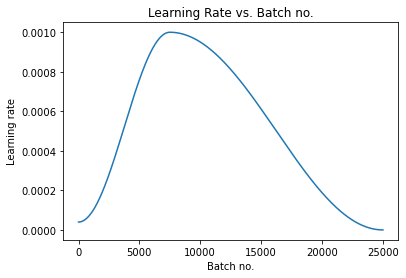

In [23]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

## Evaluación de los resultados

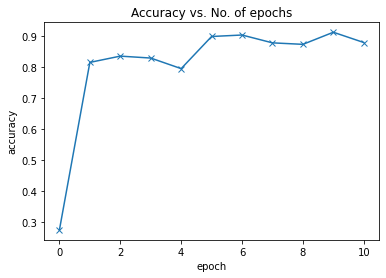

In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

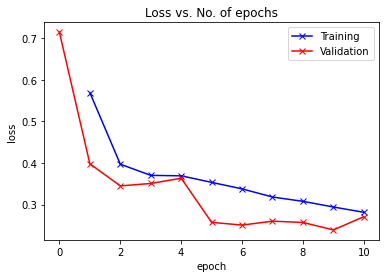

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

Ahora voy a utilizar el dataset 'test' para ver qué tan bien está etiquetando el modelo. Siguiendo el mismo procedimiento, cargo el dataset, muevo los datos al GPU y luego con la función *predict_image* puedo pasarle una imagen y el modelo que elegi y obtener la prediccion. Luego la comparo con la máscara correpondiente. 

In [26]:
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)
#Muevo los datos al GPU.
test_loader = DeviceDataLoader(test_dl, device)

In [27]:
#Test
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)  # Convert to a batch of 1
    yb = model(xb) # Get predictions from model
    return yb

In [103]:
img, label = test_dataset[1209]
pred = predict_image(img, model).cpu().detach().numpy()
print(pred.shape)
mask_pred = np.zeros([384,384,2])
mask_pred[:,:,0] = pred[:,1,:,:] #rojo = 1 = nubes
mask_pred[:,:,1] = pred[:,0,:,:] #verde = 0 = no nubes
print(mask_pred.shape)


(1, 2, 384, 384)
(384, 384, 2)


In [104]:
from skimage import data
from skimage.filters import threshold_otsu

# Load image
image = mask_pred

# Threshold image to binary
thresh = threshold_otsu(image)
binary = image > thresh

# Make 3 channel RGB image same dimensions
RGB = np.zeros((binary.shape[0],binary.shape[1],3), dtype=np.uint8)

# Make True pixels red
RGB[binary]  = [255,0,0]
# Make False pixels blue
RGB[~binary] = [0,0,255]

# Display result
Image.fromarray(RGB).show()

IndexError: boolean index did not match indexed array along dimension 2; dimension is 3 but corresponding boolean dimension is 2

In [150]:

def test_plot(num, test_dataset):
    
    img, label = test_dataset[num]
    pred = predict_image(img, model).cpu().detach().numpy()
    mask_pred = np.zeros([384,384,3])
    mask_pred[:,:,0] = pred[:,0,:,:]*255 #no nubes = 0 = rojo
    mask_pred[:,:,1] = pred[:,1,:,:]*255 #nubes = 1 = verde
    
    plt.figure(num, figsize=(15,15))
    
    plt.subplot(131)
    plt.title('Imagen RGB')
    plt.imshow(test_dataset.open_as_array(num))

    plt.subplot(132)
    plt.title('Máscara predicha')
    plt.imshow(mask_pred)
#plt.cm.binary_
    plt.subplot(133)
    plt.title('Máscara real')
    plt.imshow(test_dataset.open_mask(num))

    plt.show()

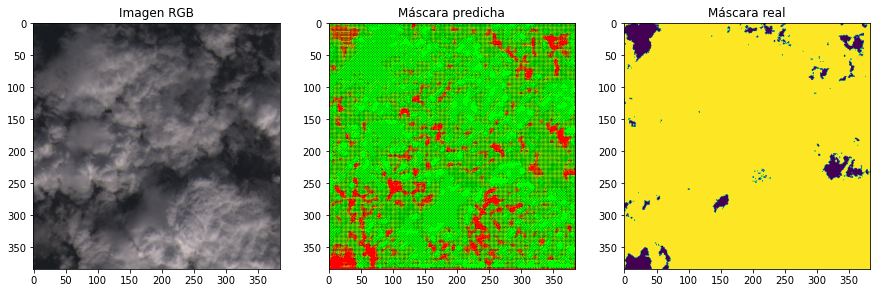

In [169]:
test_plot(296,test_dataset)

Finalmente, podemos ver la perdida y la exactitud del modelo sobre todo el conjunto de datos de testeo. Se espera que estos valores sean similares para este conjunto de datos y para el de validación. Si no lo son, puede ser un indicador de que es necesario un mejor conjunto de datos de validación, que contenga imágenes similares y con la misma distribución que el conjunto de datos de testeo.

In [32]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.26655852794647217, 'val_acc': 0.8802840709686279}

In [70]:
#Plataforma para guardar los resultados 
!pip install jovian --upgrade -q
import jovian 

torch.save(model.state_dict(), 'Deteccion de nubes')

jovian.reset()

jovian.log_hyperparams(Modelo='UNET',
                       Loss_fn = 'nn.CrossEntropyLoss',
                       batch_size = batch_size,
                       epochs = epochs, 
                       lr = max_lr, 
                       scheduler='one-cycle', 
                       weight_decay = weight_decay, 
                       grad_clip = grad_clip,
                       opt = opt_func.__name__, 
                       time = time)

jovian.log_metrics(best_acc=0.9133, test_loss=result.get('val_loss'), test_acc=result.get('val_acc') )

jovian.commit(project=project_name, outputs=['Deteccion de nubes.pth'], environment=None)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.
[jovian] Metrics logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/paula-rj/Deteccion de nubes


<IPython.core.display.Javascript object>

Este código puede encontrarse en Kaggle y Github.

## Fuentes y bibliografía
* Código para la creacion del dataset original no ampliado, 38Cloud: https://github.com/SorourMo/38-Cloud-A-Cloud-Segmentation-Dataset
* Clase CloudDataset: https://medium.com/analytics-vidhya/how-to-create-a-custom-dataset-loader-in-pytorch-from-scratch-for-multi-band-satellite-images-c5924e908edf
* S. Mohajerani and P. Saeedi. "Cloud-Net: An End-to-end Cloud Detection Algorithm for Landsat 8 Imagery". (forthcoming) 2019. to appear at IEEE International Geoscience and Remote Sensing Symposium (IGARSS). URL: https://arxiv.org/pdf/1901.10077.pdf
* Modelo U-Net: https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
* Funciones varias: curso de Deep Learnig https://jovian.ml/forum/c/pytorch-zero-to-gans/18
* Explicación detallada sobre las redes neuronales convolucionales: https://cs231n.github.io/convolutional-networks/
* Explicación detallada sobre el modelo U-Net: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
* Explicación detallada de las funciones de optimización
* Dive into Deep Learning (libro): https://d2l.ai/index.html
* Towards Data Science (post explicativos, tomé varias imágenes de esta cuenta): 
http://deeplearning.net/tutorial/fcn_2D_segm.html

Semantic segmentation
https://la.mathworks.com/help/vision/ug/semantic-segmentation-with-deep-learning.html#mw_6ab02754-d2fa-4330-8bea-3eeec77279da

https://www.kite.com/blog/python/image-segmentation-tutorial/#confusion-matrix